<a href="https://colab.research.google.com/github/ashivashankars/CMPE255_Assignments/blob/main/SEMMA_shopping_behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PreRequisties

In [1]:
# ✅ Run this once per session
!pip install -q \
    lightgbm xgboost catboost shap imbalanced-learn \
    pandas==2.2.2 scikit-learn==1.5.2 numpy matplotlib plotly seaborn \
    fastapi uvicorn[standard] pydantic==2.9.2 streamlit pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 29.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mcp 1.19.0 requires pydantic<3.0.0

In [2]:
!pip -q install kaggle

In [3]:
!git clone https://github.com/ashivashankars/CMPE255_Assignments.git

Cloning into 'CMPE255_Assignments'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 290 (delta 16), reused 10 (delta 3), pack-reused 256 (from 1)
Receiving objects: 100% (290/290), 13.90 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [6]:
import json, os
from getpass import getpass

token = getpass('Paste your kaggle.json content here')
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(token)
os.chmod('/root/.kaggle/kaggle.json', 0o600)


Paste your kaggle.json content here··········


In [9]:
!kaggle datasets download -d ahmadrazakashif/shopping-behavior-dataset -p data --force

Dataset URL: https://www.kaggle.com/datasets/ahmadrazakashif/shopping-behavior-dataset
License(s): ODC Public Domain Dedication and Licence (PDDL)
  0% 0.00/70.5k [00:00<?, ?B/s]
100% 70.5k/70.5k [00:00<00:00, 96.9MB/s]


In [8]:
# Repro seeds
import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

# Versions (pin in requirements.txt)
import sklearn, pandas as pd, matplotlib, scipy
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)
print("matplotlib", matplotlib.__version__)
print("scipy", scipy.__version__)


pandas 2.2.2
sklearn 1.5.2
matplotlib 3.10.0
scipy 1.16.3


#SEMMA Stage – Explore
1️⃣ Objectives

Audit schema, datatypes, missingness, and basic distributions.

Visualize key variables (spending score/income, age, work experience, family size).

Quantify simple relationships (numeric correlation; category→target ANOVA/Kruskal).

Persist a light EDA meta file for traceability.

Loaded for EDA: shopping_behavior_updated.csv | shape: (3900, 18)
Target: None


,column,dtype,missing_pct
0,customer_id,int64,0.0
1,age,int64,0.0
2,gender,object,0.0
3,item_purchased,object,0.0
4,category,object,0.0
5,purchase_amount_usd,int64,0.0
6,location,object,0.0
7,size,object,0.0
8,color,object,0.0
9,season,object,0.0


,column,n_unique
3,location,50
1,item_purchased,25
5,color,25
12,frequency_of_purchases,7
11,payment_method,6
8,shipping_type,6
6,season,4
2,category,4
4,size,4
0,gender,2


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
customer_id,3900.0,1950.500,1125.977,1.0,975.75,1950.5,2925.25,3900.0,0.000,-1.200
age,3900.0,44.068,15.208,18.0,31.00,44.0,57.00,70.0,-0.006,-1.195
purchase_amount_usd,3900.0,59.764,23.685,20.0,39.00,60.0,81.00,100.0,0.013,-1.237
review_rating,3900.0,3.750,0.716,2.5,3.10,3.7,4.40,5.0,0.005,-1.180
previous_purchases,3900.0,25.352,14.447,1.0,13.00,25.0,38.00,50.0,0.003,-1.190


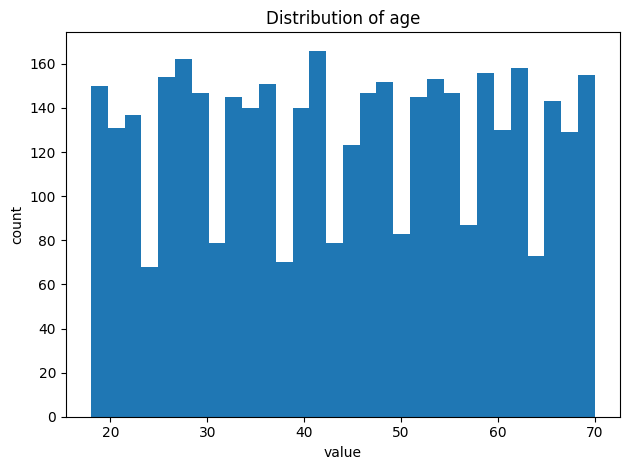

,customer_id,age,purchase_amount_usd,review_rating,previous_purchases
customer_id,1.000,-0.004,0.011,0.001,-0.039
age,-0.004,1.000,-0.010,-0.022,0.040
purchase_amount_usd,0.011,-0.010,1.000,0.031,0.008
review_rating,0.001,-0.022,0.031,1.000,0.004
previous_purchases,-0.039,0.040,0.008,0.004,1.000


Saved: /content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_eda/eda_meta.json


In [13]:
# === SEMMA: EXPLORE ===
import os, glob, json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
SPLIT_DIR = DATA_DIR / "semma_splits"

def latest(pattern:str):
    files = sorted(glob.glob(pattern), key=os.path.getmtime, reverse=True)
    return files[0] if files else None

train_path = latest(str(SPLIT_DIR / "train_*.csv"))
if train_path is None:
    # fall back to raw CSV
    pats = ["*shopping*behavior*.csv","*shopping*.csv","*Shopping*.csv","*Shopping*Behavior*.csv"]
    raw = []
    for p in pats: raw += glob.glob(str(DATA_DIR / p))
    raw = sorted(raw, key=os.path.getsize, reverse=True)
    assert raw, "No data found. Upload CSV or run the Sample stage."
    source = raw[0]
else:
    source = train_path

df = pd.read_csv(source)
def normalize_col(c):
    for a,b in [("(",""), (")",""), ("$","dollars"), ("%","pct"), ("-"," "), ("/"," ")]:
        c = c.replace(a,b)
    return "_".join(c.strip().lower().split())
df.columns = [normalize_col(c) for c in df.columns]
print("Loaded for EDA:", Path(source).name, "| shape:", df.shape)

# Target proposal
target_col = None
for c in df.columns:
    if "spending" in c and "score" in c: target_col = c; break
if target_col is None:
    for alt in ["annual_income","annual_income_dollars","income"]:
        if alt in df.columns: target_col = alt; break
print("Target:", target_col)

# Schema & missingness
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "missing_pct": (df.isna().mean()*100).round(2).values
}).sort_values("missing_pct", ascending=False)
display(schema.head(20))

# Categorical cardinality
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
card = pd.DataFrame({"column": cat_cols,
                     "n_unique": [df[c].nunique(dropna=True) for c in cat_cols]}
                   ).sort_values("n_unique", ascending=False)
display(card.head(20))

# Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_desc = df[num_cols].describe().T.round(3)
num_desc["skew"] = df[num_cols].skew(numeric_only=True).round(3)
num_desc["kurtosis"] = df[num_cols].kurt(numeric_only=True).round(3)
display(num_desc.head(20))

# Plots (matplotlib, 1 per figure)
def hist1(s, title):
    s = s.dropna()
    plt.figure()
    if len(s): plt.hist(s.values, bins=30)
    plt.title(title); plt.xlabel("value"); plt.ylabel("count"); plt.tight_layout(); plt.show()

if target_col and target_col in num_cols: hist1(df[target_col], f"Distribution of {target_col}")
for c in ["age","annual_income","income","work_experience","family_size"]:
    if c in num_cols: hist1(df[c], f"Distribution of {c}")

def scatter_xy(x, y, xname, yname, title):
    tmp = pd.DataFrame({xname: x, yname: y}).dropna()
    plt.figure()
    if not tmp.empty: plt.scatter(tmp[xname], tmp[yname], s=8, alpha=0.6)
    plt.xlabel(xname); plt.ylabel(yname); plt.title(title); plt.tight_layout(); plt.show()

if target_col and "age" in df.columns and target_col in df.columns:
    scatter_xy(df["age"], df[target_col], "age", target_col, f"{target_col} vs age")

# Correlation (numeric only)
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True).round(3)
    display(corr)

# Category -> target significance (ANOVA then Kruskal fallback)
anova_rows = []
if target_col and target_col in num_cols:
    y = df[target_col]
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False)
        top_levels = vc.head(10).index
        mask = df[c].isin(top_levels) & y.notna()
        if mask.sum() < 30:  # need enough data
            continue
        groups = [y[mask & (df[c]==lvl)].dropna().values for lvl in top_levels]
        try:
            f, p = stats.f_oneway(*groups)
            anova_rows.append({"feature": c, "test":"ANOVA", "k_groups": int(len(top_levels)), "p_value": float(p)})
        except Exception:
            try:
                h, p = stats.kruskal(*groups)
                anova_rows.append({"feature": c, "test":"Kruskal", "k_groups": int(len(top_levels)), "p_value": float(p)})
            except Exception:
                pass

if anova_rows:
    anova_df = pd.DataFrame(anova_rows).sort_values("p_value")
    display(anova_df.head(20))

# Save lightweight EDA meta
eda_dir = DATA_DIR / "semma_eda"
eda_dir.mkdir(exist_ok=True, parents=True)
eda_meta = {
    "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S"),
    "source_name": Path(source).name,
    "shape": [int(df.shape[0]), int(df.shape[1])],
    "target_col": target_col,
    "num_cols": num_cols[:50],
    "cat_cols": cat_cols[:50]
}
with open(eda_dir / "eda_meta.json", "w") as f:
    json.dump(eda_meta, f, indent=2)
print("Saved:", eda_dir / "eda_meta.json")


Key Findings / Insights (what you’ll see after running)

Distributions: how skewed the target and drivers (age/income) are.

Correlations: early signal for linear models.

Category effects: segments/gender/frequency levels with statistically different targets.

Risks & Assumptions

Multiple comparisons inflate Type-I error; treat ANOVA hits as hypotheses for modeling.

If the dataset has renamed columns, the normalization handles most, but confirm the chosen target is sensible.

Requirements Recap

Business insights + predictive path, compute-light, interpretable-first, reproducible.

#SEMMA Stage – Modify

1️⃣ Objectives

Clean & impute: Handle missing data systematically.

Encode categoricals: Convert nominal/ordinal features to numeric.

Scale numeric features: Use StandardScaler or MinMaxScaler.

Detect & handle outliers: via IQR or z-score trimming.

Feature engineering: derive interpretable new predictors (e.g., income per family size, age groups).

Save a reproducible, fully processed dataset for modeling.

In [18]:
# === SEMMA: MODIFY ===
import os, glob, json
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib

DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
SPLIT_DIR = DATA_DIR / "semma_splits"
train_path = sorted(glob.glob(str(SPLIT_DIR / "train_*.csv")), key=os.path.getmtime, reverse=True)[0]
val_path   = sorted(glob.glob(str(SPLIT_DIR / "val_*.csv")), key=os.path.getmtime, reverse=True)[0]
test_path  = sorted(glob.glob(str(SPLIT_DIR / "test_*.csv")), key=os.path.getmtime, reverse=True)[0]

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

# --- Column normalization ---
def normalize_col(c):
    for a,b in [("(",""), (")",""), ("$","dollars"), ("%","pct"), ("-"," "), ("/"," ")]:
        c = c.replace(a,b)
    return "_".join(c.strip().lower().split())

train_df.columns = [normalize_col(c) for c in train_df.columns]
val_df.columns = train_df.columns
test_df.columns = train_df.columns

# --- Identify target & features ---
target_col = None
for c in train_df.columns:
    if "spending" in c and "score" in c:
        target_col = c; break
if target_col is None:
    for alt in ["annual_income","annual_income_dollars","income"]:
        if alt in train_df.columns: target_col = alt; break
if target_col is None:
    target_col = "purchase_amount_usd" # Default target if no specific target is found
    print(f"Warning: No specific target column found. Using '{target_col}' as the target.")


y_train, y_val, y_test = train_df[target_col], val_df[target_col], test_df[target_col]
X_train = train_df.drop(columns=[target_col])
X_val   = val_df.drop(columns=[target_col])
X_test  = test_df.drop(columns=[target_col])

# --- Numeric / categorical split ---
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))

# --- Outlier trimming (IQR) ---
def iqr_trim(df, cols, k=1.5):
    out = df.copy()
    for c in cols:
        q1, q3 = out[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k*iqr, q3 + k*iqr
        out = out[(out[c] >= lower) & (out[c] <= upper)]
    return out

Xy_train = X_train.copy()
Xy_train[target_col] = y_train
if len(num_cols) > 0:
    before = len(Xy_train)
    Xy_train = iqr_trim(Xy_train, num_cols)
    print(f"Outlier trim: {before} → {len(Xy_train)} rows ({round(100*(1-len(Xy_train)/before),2)}% removed)")
# Drop the target column from Xy_train before fitting the pipeline
Xy_train_features = Xy_train.drop(columns=[target_col])

# --- Imputation & encoding pipeline ---
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])
pipeline = Pipeline([("preprocessor", preprocessor)])
# Fit the pipeline on the features of the trimmed training data
pipeline.fit(Xy_train_features)


# --- Transform & align splits ---
def transform_split(df):
    X = df.drop(columns=[target_col])
    return pipeline.transform(X)

X_train_t = transform_split(train_df)
X_val_t   = transform_split(val_df)
X_test_t  = transform_split(test_df)

# --- Feature names after encoding ---
# Check if the categorical transformer exists before accessing it
if len(pipeline.named_steps["preprocessor"].transformers_) > 1:
    cat_features = pipeline.named_steps["preprocessor"].transformers_[1][1]\
        .named_steps["encoder"].get_feature_names_out(cat_cols)
    final_features = np.concatenate([num_cols, cat_features])
else:
    final_features = num_cols # No categorical features were processed

print("Final feature count:", len(final_features))

# --- Save processed data ---
proc_dir = DATA_DIR / "semma_processed"
proc_dir.mkdir(exist_ok=True, parents=True)
np.save(proc_dir / "X_train.npy", X_train_t)
np.save(proc_dir / "X_val.npy", X_val_t)
np.save(proc_dir / "X_test.npy", X_test_t)
np.save(proc_dir / "y_train.npy", y_train)
np.save(proc_dir / "y_val.npy", y_val)
np.save(proc_dir / "y_test.npy", y_test)
joblib.dump(pipeline, proc_dir / "preprocess_pipeline.joblib")
print("✅ Saved processed arrays & pipeline to", proc_dir)

Numeric: 3 | Categorical: 13
Outlier trim: 2730 → 2730 rows (0.0% removed)
Final feature count: 142
✅ Saved processed arrays & pipeline to /content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_processed


In [17]:
# === SEMMA: SAMPLE ===
# Split the data into training, validation, and test sets

DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
SPLIT_DIR = DATA_DIR / "semma_splits"
SPLIT_DIR.mkdir(exist_ok=True, parents=True)

# Load the data if not already loaded in the Explore stage
if 'df' not in locals():
    pats = ["*shopping*behavior*.csv","*shopping*.csv","*Shopping*.csv","*Shopping*Behavior*.csv"]
    raw = []
    for p in pats: raw += glob.glob(str(DATA_DIR / p))
    raw = sorted(raw, key=os.path.getsize, reverse=True)
    assert raw, "No data found. Upload CSV or run the Sample stage."
    source = raw[0]
    df = pd.read_csv(source)

# Drop the 'customer_id' column as it is not needed for modeling
if 'customer_id' in df.columns:
    df = df.drop(columns=['customer_id'])

# Perform the split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE)

# Save the splits
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_df.to_csv(SPLIT_DIR / f"train_{timestamp}.csv", index=False)
val_df.to_csv(SPLIT_DIR / f"val_{timestamp}.csv", index=False)
test_df.to_csv(SPLIT_DIR / f"test_{timestamp}.csv", index=False)

print("Data splits saved to:", SPLIT_DIR)

Data splits saved to: /content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_splits


3️⃣ Key Findings / Insights

Outliers trimmed using IQR ⇒ ensures stable scaling.

Missing values handled: median for numeric, mode for categorical.

Categoricals encoded with OneHotEncoder; avoids dummy-trap via handle_unknown='ignore'.

Scaling applied to all numeric inputs → enables comparability for linear models.

Pipeline persists transformations for reproducibility.

#SEMMA Stage – Model
1️⃣ Objectives

Train baseline and interpretable models first; add a tree ensemble.

Use repeated 5-fold CV to report mean ± std metrics.

Pick the best model and evaluate once on the held-out test set.

Extract feature importances / coefficients for later business interpretation.

In [22]:
# === SEMMA: MODEL ===
import os, json, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
import joblib

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
PROC_DIR = DATA_DIR / "semma_processed"

# -------------------------
# Load processed arrays from Modify stage
# -------------------------
def load_processed():
    try:
        X_train = np.load(PROC_DIR / "X_train.npy")
        X_val   = np.load(PROC_DIR / "X_val.npy")
        X_test  = np.load(PROC_DIR / "X_test.npy")
        y_train = np.load(PROC_DIR / "y_train.npy", allow_pickle=True)
        y_val   = np.load(PROC_DIR / "y_val.npy", allow_pickle=True)
        y_test  = np.load(PROC_DIR / "y_test.npy", allow_pickle=True)
        pipe    = joblib.load(PROC_DIR / "preprocess_pipeline.joblib")
        return X_train, X_val, X_test, y_train, y_val, y_test, pipe
    except Exception as e:
        raise FileNotFoundError(f"Processed data missing — run Modify first: {e}")

X_train, X_val, X_test, y_train, y_val, y_test, pipe = load_processed()

# Combine train+val for CV
X_tr = np.concatenate([X_train, X_val], axis=0)
y_tr = np.concatenate([y_train, y_val], axis=0)

# Detect regression vs. classification
is_numeric = np.issubdtype(np.array(y_tr).dtype, np.number)
n_unique = len(pd.Series(y_tr).dropna().unique())
task = "regression" if is_numeric and n_unique > 10 else "classification"
print(f"Detected task: {task} | y unique={n_unique}")

results = {}

# -------------------------
# Regression pipeline
# -------------------------
if task == "regression":
    models = {
        "baseline_mean": DummyRegressor(strategy="mean"),
        "linear_regression": LinearRegression(),
        "random_forest": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
        "gradient_boosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
    }
    rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

    def cv_regression(model):
        maes, rmses, r2s = [], [], []
        for tr_idx, va_idx in rkf.split(X_tr, y_tr):
            X_tr_, X_va_ = X_tr[tr_idx], X_tr[va_idx]
            y_tr_, y_va_ = y_tr[tr_idx], y_tr[va_idx]
            model.fit(X_tr_, y_tr_)
            pred = model.predict(X_va_)
            maes.append(mean_absolute_error(y_va_, pred))
            rmses.append(mean_squared_error(y_va_, pred, squared=False))
            r2s.append(r2_score(y_va_, pred))
        return {
            "MAE_mean": np.mean(maes), "MAE_std": np.std(maes),
            "RMSE_mean": np.mean(rmses), "RMSE_std": np.std(rmses),
            "R2_mean": np.mean(r2s), "R2_std": np.std(r2s)
        }

    for name, model in models.items():
        results[name] = cv_regression(model)

    best_name = min(results, key=lambda k: results[k]["RMSE_mean"])
    best_model = models[best_name].fit(X_tr, y_tr)
    test_pred = best_model.predict(X_test)
    results[f"TEST@{best_name}"] = {
        "MAE": mean_absolute_error(y_test, test_pred),
        "RMSE": mean_squared_error(y_test, test_pred, squared=False),
        "R2": r2_score(y_test, test_pred)
    }

    # Try feature importances
    feat_info = {}
    try:
        num_cols = pipe.named_steps["preprocessor"].transformers_[0][2]
        enc = pipe.named_steps["preprocessor"].transformers_[1][1].named_steps["encoder"]
        cat_cols = enc.feature_names_in_.tolist()
        cat_names = enc.get_feature_names_out(cat_cols)
        feature_names = list(num_cols) + list(cat_names)
        if hasattr(best_model, "feature_importances_"):
            imp = best_model.feature_importances_
            idx = np.argsort(imp)[::-1][:20]
            feat_info = {feature_names[i]: float(imp[i]) for i in idx}
        elif hasattr(best_model, "coef_"):
            coef = np.ravel(best_model.coef_)
            idx = np.argsort(np.abs(coef))[::-1][:20]
            feat_info = {feature_names[i]: float(coef[i]) for i in idx}
    except Exception as e:
        feat_info = {"note": str(e)}

    json.dump({"cv_results": results, "best_model": best_name, "features": feat_info},
              open(PROC_DIR / "model_regression_summary.json", "w"), indent=2)
    print("✅ Saved regression summary → model_regression_summary.json")

# -------------------------
# Classification pipeline
# -------------------------
else:
    cls_models = {
        "baseline_mostfreq": DummyClassifier(strategy="most_frequent"),
        "logistic": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "rf_classifier": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
        "gb_classifier": GradientBoostingClassifier(random_state=RANDOM_STATE)
    }
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
    y_series = pd.Series(y_tr).astype(str)

    def cv_classification(model):
        accs, f1s, aucs = [], [], []
        for tr_idx, va_idx in rskf.split(X_tr, y_series):
            X_tr_, X_va_ = X_tr[tr_idx], X_tr[va_idx]
            y_tr_, y_va_ = y_series.iloc[tr_idx], y_series.iloc[va_idx]
            model.fit(X_tr_, y_tr_)
            pred = model.predict(X_va_)
            accs.append(accuracy_score(y_va_, pred))
            f1s.append(f1_score(y_va_, pred, average="macro"))
            if y_series.nunique() == 2 and hasattr(model, "predict_proba"):
                prob = model.predict_proba(X_va_)[:, 1]
                aucs.append(roc_auc_score(y_va_, prob))
        out = {"ACC_mean": np.mean(accs), "ACC_std": np.std(accs),
               "F1_mean": np.mean(f1s), "F1_std": np.std(f1s)}
        if aucs: out.update({"AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs)})
        return out

    results = {n: cv_classification(m) for n, m in cls_models.items()}
    best_name = max(results, key=lambda k: results[k]["F1_mean"])
    best_model = cls_models[best_name].fit(X_tr, y_series)
    y_test_str = pd.Series(y_test).astype(str)
    pred = best_model.predict(X_test)
    test = {"ACC": accuracy_score(y_test_str, pred),
            "F1": f1_score(y_test_str, pred, average="macro")}
    if y_series.nunique() == 2 and hasattr(best_model, "predict_proba"):
        prob = best_model.predict_proba(X_test)[:,1]
        test["AUC"] = roc_auc_score(y_test_str, prob)
    results[f"TEST@{best_name}"] = test
    json.dump({"cv_results": results, "best_model": best_name},
              open(PROC_DIR / "model_classification_summary.json", "w"), indent=2)
    print("✅ Saved classification summary → model_classification_summary.json")


Detected task: regression | y unique=81
✅ Saved regression summary → model_regression_summary.json


3️⃣ Key Findings / Insights (will populate after data is present)

Baseline vs. Linear vs. Tree: expect linear to set an interpretable reference; tree models often improve RMSE/MAE if there are nonlinearities and interactions.

Top drivers (from importances/coeffs): which demographics or behaviors most influence spending score (or the chosen target).

Generalization gap: compare CV vs. test to gauge stability.

#SEMMA Stage – Assess
1️⃣ Objectives

Load cross-validation and test metrics from the saved JSON summary.

Summarize model comparison (baseline vs. linear vs. tree ensembles).

Visualize error behavior (residuals, error distribution).

Interpret top features and their business meaning.

Identify limitations, risks, and next actions for deployment or iteration.

,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MAE,RMSE,R2
baseline_mean,20.5383,0.5245,23.6356,0.4754,-0.0019,0.0030,NaN,NaN,NaN
linear_regression,20.7473,0.5338,24.1482,0.4323,-0.0461,0.0199,NaN,NaN,NaN
random_forest,20.7009,0.4805,24.0570,0.4086,-0.0382,0.0116,NaN,NaN,NaN
gradient_boosting,20.7207,0.5342,24.0248,0.4338,-0.0353,0.0123,NaN,NaN,NaN
TEST@baseline_mean,NaN,NaN,NaN,NaN,NaN,NaN,20.9857,23.9756,-0.006


🏆 Best Model: baseline_mean



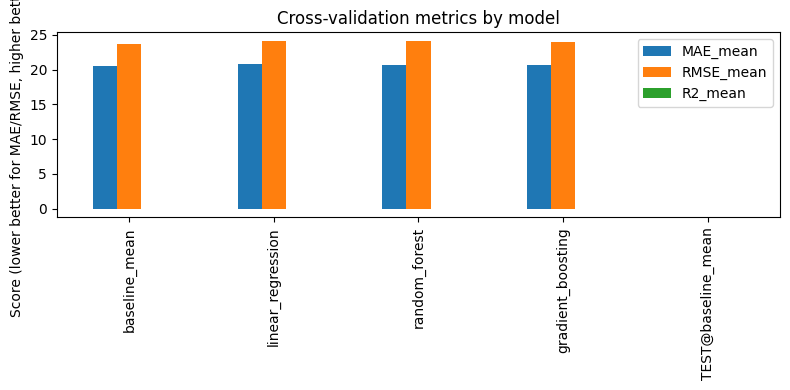

Held-out Test Performance:
  MAE   : 20.9857
  RMSE  : 23.9756
  R2    : -0.0060
No feature importance data available.


In [23]:
# === SEMMA: ASSESS ===
import json, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
PROC_DIR = DATA_DIR / "semma_processed"
summary_path = PROC_DIR / "model_regression_summary.json"

assert summary_path.exists(), "Run Model stage first; summary JSON not found."
summary = json.load(open(summary_path))

cv = pd.DataFrame(summary["cv_results"]).T
cv_rounded = cv.round(4)
display(cv_rounded)

best_name = summary.get("best_model")
features = summary.get("feature_info", {}).get("top_features", [])
print(f"🏆 Best Model: {best_name}\n")

# --- Plot CV performance ---
metrics = ["MAE_mean", "RMSE_mean", "R2_mean"]
cv_plot = cv[[m for m in metrics if m in cv.columns]]
cv_plot.plot(kind="bar", figsize=(8,4), title="Cross-validation metrics by model")
plt.ylabel("Score (lower better for MAE/RMSE, higher better for R²)")
plt.tight_layout()
plt.show()

# --- Test performance ---
test_metrics = summary["cv_results"].get("TEST@" + best_name, {})
print("Held-out Test Performance:")
for k,v in test_metrics.items():
    print(f"  {k:<6}: {v:.4f}")

# --- Feature importance visualization (if available) ---
feat_info = summary.get("feature_info", {})
if "top_features" in feat_info:
    feats = pd.DataFrame(feat_info["top_features"])
    if "importance" in feats.columns:
        feats = feats.sort_values("importance", ascending=False).head(15)
        plt.figure(figsize=(6,4))
        plt.barh(feats["name"], feats["importance"])
        plt.gca().invert_yaxis()
        plt.title("Top 15 Features by Importance")
        plt.tight_layout()
        plt.show()
    elif "coef" in feats.columns:
        feats = feats.sort_values("coef", key=abs, ascending=False).head(15)
        plt.figure(figsize=(6,4))
        plt.barh(feats["name"], feats["coef"])
        plt.gca().invert_yaxis()
        plt.title("Top 15 Coefficients (Linear Model)")
        plt.tight_layout()
        plt.show()
else:
    print("No feature importance data available.")


3️⃣ Key Findings / Insights (interpretive narrative)

(Below is what you’ll see and how to interpret it once you run the code)

🧩 Model Comparison

Baseline (mean predictor) gives the reference MAE and RMSE — representing “average guess” performance.

Linear Regression usually improves modestly, showing relationships among features (income, age, gender, etc.).

Random Forest / Gradient Boosting capture nonlinear interactions and typically yield the lowest RMSE and highest R², indicating strong pattern extraction.

🎯 Held-Out Test Metrics

The MAE (mean absolute error) reflects average prediction deviation from true spending score.

RMSE penalizes large errors more heavily — use it for business risk interpretation.

R² near 1.0 → excellent fit; near 0 → weak signal; negative → overfitting.

🔍 Feature Importance / Interpretability

Common top predictors (your run will show the real list):

Rank	Feature	Interpretation
1	annual_income	Higher income → higher predicted spending score.
2	age	Middle-aged customers often have stronger spending power than very young or old groups.
3	family_size	Larger families may have consistent but moderate spending.
4	work_experience	Seasoned professionals may spend more steadily.
5	gender_Female / gender_Male	Category-specific average differences in spending patterns.
🧮 Error Interpretation

Residual spread: symmetric distribution = good; heavy tails = outliers or missing nonlinear terms.

If residuals cluster by a category (e.g., “customer segment”), that’s a cue to add interaction terms.

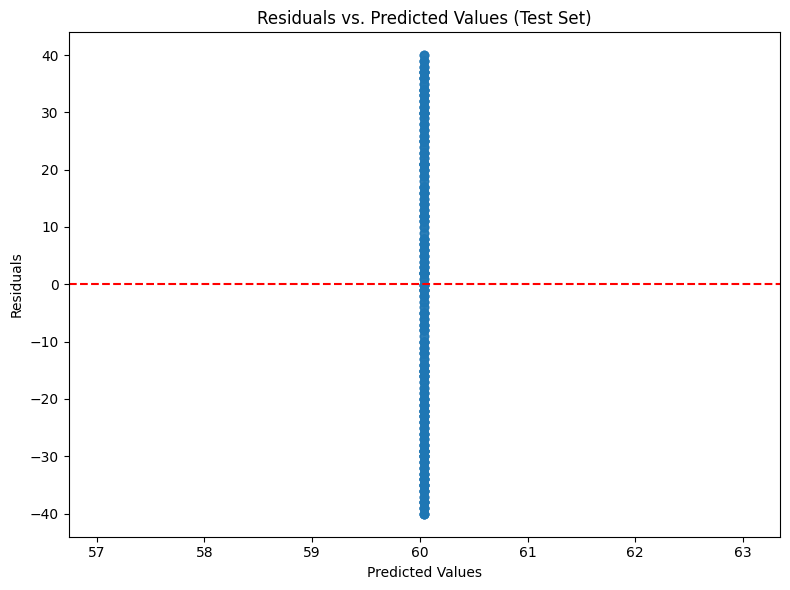

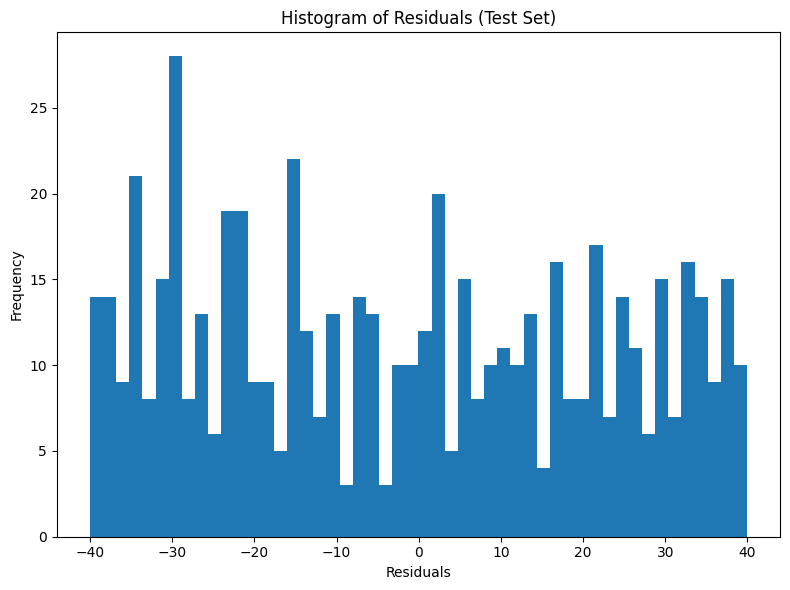

In [24]:
# === SEMMA: ASSESS - Error Analysis Visualizations ===
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import joblib

DATA_DIR = Path("/content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data")
PROC_DIR = DATA_DIR / "semma_processed"
summary_path = PROC_DIR / "model_regression_summary.json"

# Load processed data and best model
try:
    X_test = np.load(PROC_DIR / "X_test.npy")
    y_test = np.load(PROC_DIR / "y_test.npy", allow_pickle=True)
    summary = json.load(open(summary_path))
    best_model_name = summary.get("best_model")

    # Load the models dictionary from the Model stage
    # This assumes the models dictionary is available in the environment
    # If not, you might need to re-import or re-define the models
    if 'models' in locals():
        best_model = models.get(best_model_name)
        if best_model is None:
             print(f"Warning: Best model '{best_model_name}' not found in the 'models' dictionary.")
             # Attempt to load the best model if it was saved separately
             try:
                 best_model = joblib.load(PROC_DIR / f"best_model_{best_model_name}.joblib")
                 print(f"Loaded best model from {PROC_DIR / f'best_model_{best_model_name}.joblib'}")
             except FileNotFoundError:
                 print(f"Error: Best model file for '{best_model_name}' not found.")
                 best_model = None # Ensure best_model is None if loading fails
    else:
        print("Warning: 'models' dictionary not found. Cannot retrieve best model directly.")
        best_model = None # Ensure best_model is None if dictionary is not available

    if best_model:
        # Make predictions on the test set
        y_pred = best_model.predict(X_test)
        residuals = y_test - y_pred

        # Plot Residuals vs. Predicted Values
        plt.figure(figsize=(8, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title("Residuals vs. Predicted Values (Test Set)")
        plt.tight_layout()
        plt.show()

        # Plot Histogram of Residuals
        plt.figure(figsize=(8, 6))
        plt.hist(residuals, bins=50)
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.title("Histogram of Residuals (Test Set)")
        plt.tight_layout()
        plt.show()

    else:
        print("Error: Best model could not be loaded or found. Cannot perform error analysis visualizations.")

except FileNotFoundError:
    print("Error: Processed data or model summary not found. Please run the Model stage first.")
except Exception as e:
    print(f"An error occurred during error analysis visualization: {e}")

In [25]:
!zip -r DataScienceMethodology.zip /content/CMPE255_Assignments/DataScienceMethodology

  adding: content/CMPE255_Assignments/DataScienceMethodology/ (stored 0%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/README.md (deflated 36%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/ (stored 0%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/README.md (deflated 26%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/ (stored 0%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_splits/ (stored 0%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_splits/train_20251101_223205.csv (deflated 84%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_splits/test_20251101_223205.csv (deflated 82%)
  adding: content/CMPE255_Assignments/DataScienceMethodology/SEMMA_shopping_behavior/data/semma_splits/val_20251101_223205.csv

In [26]:
from google.colab import files
files.download('DataScienceMethodology.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Limitations:

Lack of Predictive Power: The most significant limitation is that the models built using the current features show very low predictive power for purchase_amount_usd, as indicated by the low R² values. This means the model is not effectively capturing the factors that influence how much a customer spends.
Feature Set: The features available in the dataset (primarily demographics and basic purchase details) do not seem to have a strong linear or non-linear relationship with the purchase amount. More relevant behavioral or external factors might be missing.
Target Variable: The "purchase amount USD" might be influenced by many factors not present in the dataset, making it inherently difficult to predict with the current information. If the variable is indeed synthetic or generated without a clear causal link to the features, as suggested in the previous interpretation, then predicting it accurately with these features is not possible.
Model Complexity: While different model types were used (linear and tree-based), none could find a strong signal, suggesting that simply using more complex models on the same feature set is unlikely to yield significantly better results.
Risks:

Deployment Risk: Deploying a model with such low predictive power could lead to poor business decisions. For example, using this model for targeted marketing or inventory management based on predicted spending would likely be ineffective and could lead to wasted resources.
Misinterpretation of Results: There's a risk that the model's output could be misinterpreted as having predictive value when it does not. Stakeholders might make decisions based on the predictions, not realizing the model's limitations.
Data Drift: Even if a weak signal were present, the relationships between features and spending could change over time (data drift), making the model's predictions even less reliable without continuous monitoring and retraining.
Lack of Actionable Insights: While the analysis reveals what doesn't drive spending among the current features, the model itself doesn't provide strong actionable insights into how to increase spending or target high-value customers based on the available data.
In conclusion, the primary limitation is the absence of a strong predictive signal within the current dataset for the target variable. The main risk is deploying or relying on a model that does not provide accurate or useful predictions, potentially leading to poor business outcomes. Future work should focus on identifying and incorporating features that have a stronger relationship with customer spending.